In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [2]:
print('Tensorflow => ',tf.__version__)
print('Keras      => ',tf.keras.__version__)
print('Numpy      => ',np.__version__)

Tensorflow =>  2.10.0
Keras      =>  2.10.0
Numpy      =>  1.25.2


In [5]:
#gpus = tf.config.list_physical_devices('GPU')


In [ ]:
'''
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)
'''

In [4]:
'''
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
#import requests
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
'''

In [3]:
BATCH_SIZE=8
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

# LJ Speech Dataset

## Data Visualization

In [6]:
audio_binary=tf.io.read_file("D:/CDAC/Datasets/LJSpeech-1.1/wavs/LJ001-0095.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(92573,)


(92573,)


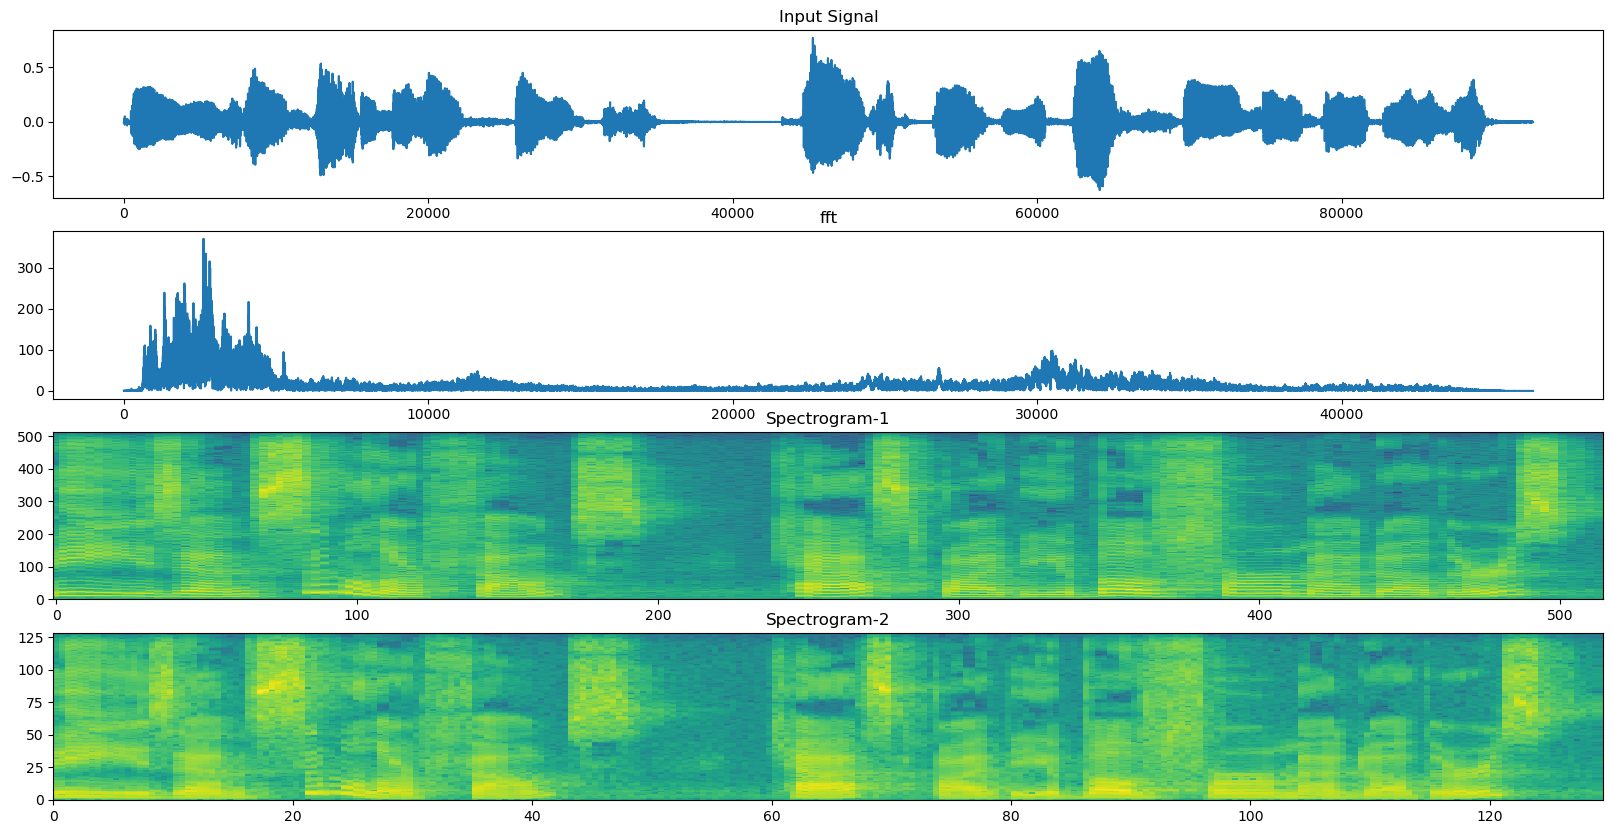

In [8]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [9]:
X

array([  0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,   2,
         2,   2,   2,   2,   3,   3,   3,   3,   3,   3,   4,   4,   4,
         4,   4,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,
         6,   7,   7,   7,   7,   7,   8,   8,   8,   8,   8,   8,   9,
         9,   9,   9,   9,  10,  10,  10,  10,  10,  10,  11,  11,  11,
        11,  11,  11,  12,  12,  12,  12,  12,  13,  13,  13,  13,  13,
        13,  14,  14,  14,  14,  14,  15,  15,  15,  15,  15,  15,  16,
        16,  16,  16,  16,  16,  17,  17,  17,  17,  17,  18,  18,  18,
        18,  18,  18,  19,  19,  19,  19,  19,  20,  20,  20,  20,  20,
        20,  21,  21,  21,  21,  21,  22,  22,  22,  22,  22,  22,  23,
        23,  23,  23,  23,  23,  24,  24,  24,  24,  24,  25,  25,  25,
        25,  25,  25,  26,  26,  26,  26,  26,  27,  27,  27,  27,  27,
        27,  28,  28,  28,  28,  28,  28,  29,  29,  29,  29,  29,  30,
        30,  30,  30,  30,  30,  31,  31,  31,  31,  31,  32,  3

In [10]:
Y

range(0, 129)

## Data Preparation

In [11]:
audio_text2={}
csv_path="D:/CDAC/Datasets/LJSpeech-1.1/metadata.csv"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split("|")[0]    
    text=line.strip().split("|")[1]    
    audio_text2[str(i)]=text  

audio_text2

{'LJ001-0001': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'LJ001-0002': 'in being comparatively modern.',
 'LJ001-0003': 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process',
 'LJ001-0004': 'produced the block books, which were the immediate predecessors of the true printed book,',
 'LJ001-0005': 'the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.',
 'LJ001-0006': 'And it is worth mention in passing that, as an example of fine typography,',
 'LJ001-0007': 'the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about 1455,',
 'LJ001-0008': 'has never been surpassed.',
 'LJ001-0009': 'Printing, then, for our purpose, may be considered as the art of

In [12]:
filepaths=["D:/CDAC/Datasets/LJSpeech-1.1/wavs/"+filename+".wav" for filename in list(audio_text2.keys())]
transcriptions=[audio_text2[str(filename)].lower() for filename in list(audio_text2.keys())]
print(len(filepaths))
print(len(transcriptions))

13100
13100


In [13]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:/CDAC/Datasets/LJSpeech-1.1/wavs/LJ001-0001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'>)


In [14]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [15]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [16]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [17]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [18]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [20]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[7.12798326e-04]
   [4.62571252e-03]
   [6.20642118e-03]
   ...
   [1.35252572e-04]
   [7.60570110e-05]
   [3.36043013e-05]]

  [[4.23590001e-03]
   [7.16409134e-03]
   [3.25928186e-03]
   ...
   [9.35634525e-05]
   [5.88791190e-05]
   [2.21005175e-05]]

  [[3.52023495e-03]
   [1.79913249e-02]
   [2.51728334e-02]
   ...
   [3.46485089e-04]
   [1.54136491e-04]
   [1.43282465e-04]]

  ...

  [[1.17299603e-02]
   [6.78249076e-03]
   [5.77665400e-03]
   ...
   [2.32442137e-04]
   [1.94887572e-04]
   [7.22361729e-05]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[5.27175982e-03]
   [8.09575431e-03]
   [1.60869583e-02]
   ...
   [1.84492674e-04]
   [1.14722949e-04]
   [1.01984711e-04]]

  [[5.57353161e-03]
   [1.64909046e-02]
   [1.31872818e-01]
   ...
   [1.4465

## Modeling 

In [21]:
normalization=tf.keras.layers.Normalization()

In [22]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)

output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Based")
model.summary()

Model: "DeepSpeech_2_Based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33, 6

In [35]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [34]:
model.compile(
    loss=ctc_loss,    
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [36]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ASR_LJSpeech-{epoch:03d}.h5")
model_path='D:/CDAC/Project/ASR-using-deepspeech2_run2/ASR_LJSpeech_Model_Final.h5'

## Training

In [37]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/100
1556/1556 [==============================] - 1222s 778ms/step - loss: 231.1278 - val_loss: 135.7378
Epoch 2/100
1556/1556 [==============================] - 925s 594ms/step - loss: 113.7319 - val_loss: 92.9715
Epoch 3/100
1556/1556 [==============================] - 902s 580ms/step - loss: 87.6615 - val_loss: 77.7421
Epoch 4/100
1556/1556 [==============================] - 907s 583ms/step - loss: 74.3132 - val_loss: 70.1336
Epoch 5/100
1556/1556 [==============================] - 914s 587ms/step - loss: 65.0813 - val_loss: 65.2436
Epoch 6/100
1556/1556 [==============================] - 905s 581ms/step - loss: 57.8168 - val_loss: 61.8543
Epoch 7/100
1556/1556 [==============================] - 905s 582ms/step - loss: 51.8262 - val_loss: 60.1734
Epoch 8/100
1556/1556 [==============================] - 899s 578ms/step - loss: 46.6948 - val_loss: 59.0833
Epoch 9/100
1556/1556 [==============================] - 911s 585ms/step - loss: 42.4319 - val_loss: 58.9033
Epoch 10/100
15

In [38]:
# save model
model.save(model_path)

## Testing

In [39]:
#obtain and decode the acoustic model's predictions
model.load_weights(model_path)

In [40]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [41]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [53]:
#test_path="C:/Users/Anand/Downloads/output.wav"
test_path="D:/CDAC/Datasets/LJSpeech-1.1/wavs/LJ001-0100.wav"
from IPython.display import Audio
# play the audio file
Audio(test_path)

In [54]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)
out

(1478, 129, 1)
1/1 [==============================] - 0s 337ms/step


<tf.Tensor: shape=(739,), dtype=int64, numpy=
array([31,  1, 31, 31, 14, 14, 14,  4,  4,  4, 31, 30, 30, 30, 20,  8,  8,
        5,  5, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 19,  5,  5, 31,
       31, 31, 31, 31, 31, 31, 31, 30, 30, 19, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 15, 31, 31, 31, 31, 13, 13,  5,  5, 31, 31, 31, 23, 23,
        8,  1, 31, 31, 31, 31, 31, 31, 20, 20, 20, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 30, 30, 30, 23, 23, 31, 31, 31, 31, 31, 31, 31,
       31, 31,  9,  9, 31, 31, 31, 31, 31, 18, 18, 31, 31, 31, 31, 31, 31,
       25, 25, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 12, 12,
        5, 31, 31, 31, 31, 31, 31, 31, 20, 20, 20, 31, 20,  5,  5, 18, 18,
       18, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 19, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       30, 30, 30,  1, 31, 31, 31, 31, 31, 31, 31, 18,

In [55]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

[LINK]a[LINK][LINK]nnnddd[LINK]   thhee[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]see[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]  s[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]o[LINK][LINK][LINK][LINK]mmee[LINK][LINK][LINK]wwha[LINK][LINK][LINK][LINK][LINK][LINK]ttt[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]   ww[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]ii[LINK][LINK][LINK][LINK][LINK]rr[LINK][LINK][LINK][LINK][LINK][LINK]yy[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]  lle[LINK][LINK][LINK][LINK][LINK][LINK][LINK]ttt[LINK]teerrr[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]s[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]   a[LINK][LINK][LINK][LINK][LINK][LINK][LINK]rrreee[LINK][LINK] ss[LIN

In [56]:
print(decode(tf.expand_dims(out,axis=0)))

tf.Tensor([  1 739], shape=(2,), dtype=int32)
and these somewhat wiry letters are suitable for the machine process, which would not do justice to letters of more generous design.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
